In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
from utils_evaluate_model import *

import random
from pathlib import Path
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import resize as tv_resize
from torch.nn.functional import pad as Fpad
import torchvision.transforms as T
from utils_ot import * 
import os, datetime, json, torch
from pathlib import Path


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:1')
    torch.cuda.FloatTensor
elif torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(device)

cuda:1


In [3]:
inception_model = InceptionV3_Multi(device=device)
inception_model.eval()

import torch.nn.functional as F

def preprocess_for_inception(x):
    # accepte x en [3,H,W] ou [N,3,H,W]
    was_3d = (x.dim() == 3)
    if was_3d:
        x = x.unsqueeze(0)          #  [1,3,H,W]
    x = (x + 1) / 2
    x = F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False)
    mean = torch.tensor([0.485,0.456,0.406], device=x.device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=x.device).view(1,3,1,1)
    x = (x - mean) / std
    return x.squeeze(0) if was_3d else x



+ Affichage dimension feature extraites par le réseau inception

In [4]:
with torch.no_grad():
    dummy = torch.randn(1, 3, 299, 299, device=device)
    feats = inception_model(dummy)      # liste de 3 tenseurs
for i, f in enumerate(feats):
    print(i, f.shape)


0 torch.Size([1, 288, 35, 35])
1 torch.Size([1, 768, 17, 17])
2 torch.Size([1, 2048, 8, 8])


22 variantes, 4 scale chacune.


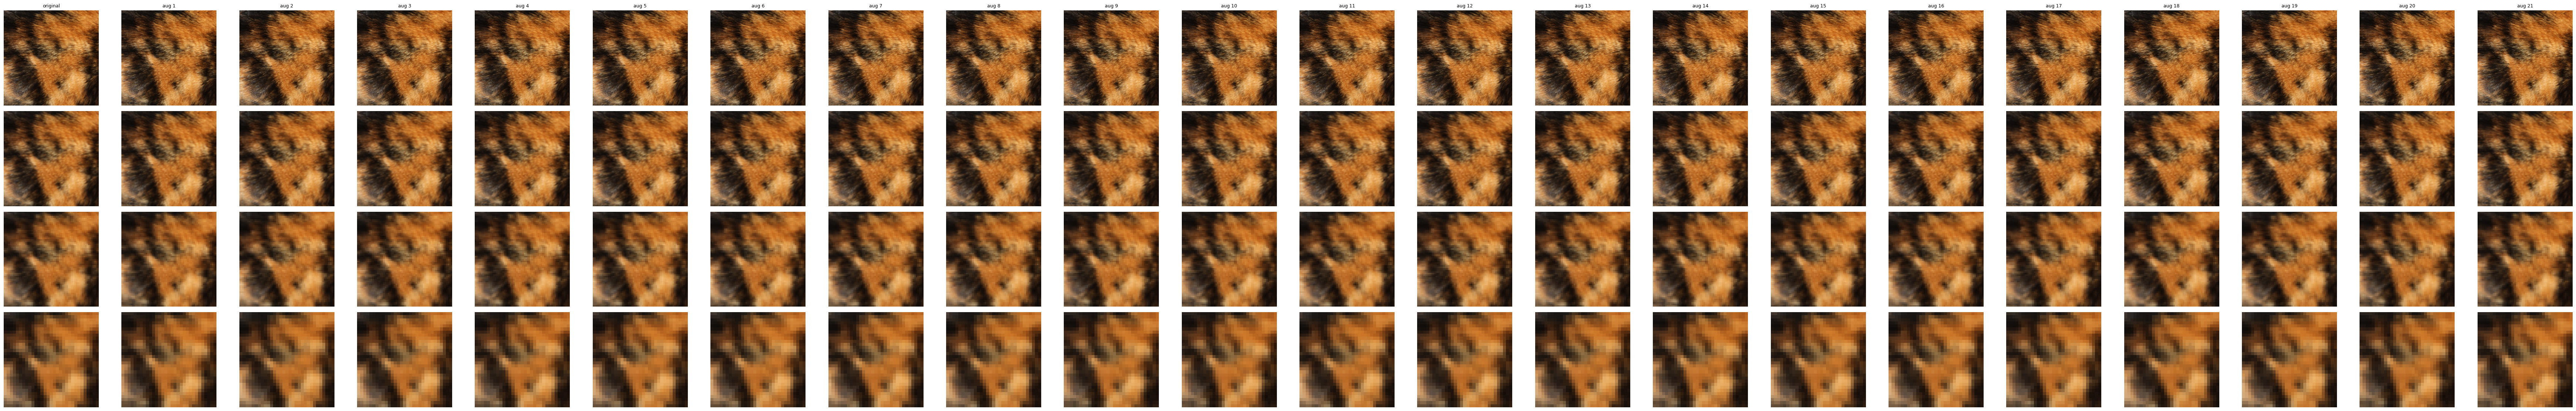

In [5]:
"""
Produit l’image originale + N_AUG variantes aléatoires (juste des petites rotations)
Construit ensuite  pour chacune la pyramide d’échelles façon SinGAN.
"""

IMG_PATH   = Path("images/real-2.png")             # image de référence
MAX_DIM    = 250                                  # côté le plus long après resize initial
MIN_DIM    = 40                                   # côté mini à l’échelle la plus coarse
RATIO      = 2                                    # facteur de downscale entre niveaux

N_AUG      = 21                                   # nombre de variantes à générer
MAX_ROT    = 5                                    # rotation ±MAX_ROT°
PAD_RATIO  = 0.20                                 # pad(reflect) = PAD_RATIO × taille

SEED       = 1                                      # fixer pour reproductibilité

class AugmentVariant(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        
    @torch.no_grad()
    def forward(self, x):
        C, H, W = x.shape

        # Pad-Rotate-Crop (pas de bordures noires)
        ph, pw = int(H * PAD_RATIO), int(W * PAD_RATIO)
        x = Fpad(x, (pw, pw, ph, ph), mode="reflect")
        angle = random.uniform(-MAX_ROT, MAX_ROT)
        x = TF.rotate(x, angle, expand=False)
        x = TF.center_crop(x, (H, W))


        return x.clamp(-1, 1)

torch.manual_seed(SEED) 
random.seed(SEED)

img   = Image.open(IMG_PATH).convert("RGB")
orig  = TF.to_tensor(img).to(device)                       # [0,1]
_, H0, W0 = orig.shape
scale = MAX_DIM / max(H0, W0)
orig  = tv_resize(orig, [int(H0*scale), int(W0*scale)], antialias=True)
orig  = orig * 2 - 1                            # [-1,1]


augmenter = AugmentVariant().to(device)
variants  = [orig] + [augmenter(orig.clone()) for _ in range(N_AUG)]

# Construction pyramids des échelles pour toutes les images de références
def build_pyramid(img):
    levels = [img.unsqueeze(0)]             
    while True:
        _, _, h, w = levels[-1].shape
        nh, nw = int(h / RATIO), int(w / RATIO)
        
        down = tv_resize(levels[-1], [nh, nw], antialias=True).to(device)  # <──
        levels.append(down)
        if nh < MIN_DIM or nw < MIN_DIM: break
    return levels

pyramids = [[lvl.to(device) for lvl in build_pyramid(v)] for v in variants]
print(f"{len(variants)} variantes, {len(pyramids[0])} scale chacune.")

# Visualisation 
def show_grid(pyramids):
    rows, cols = len(pyramids[0]), len(pyramids)
    
    if cols == 1:
        fig, axes = plt.subplots(rows, 1, figsize=(3.2, 2.8 * rows))
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(3.2 * cols, 2.8 * rows))
    
    for r in range(rows):
        for c in range(cols):
            if cols == 1:
                ax = axes[r]
            else:
                ax = axes[r, c]
            
            img_np = (pyramids[c][r].cpu().squeeze(0).permute(1, 2, 0) + 1) / 2
            ax.imshow(img_np.clamp(0, 1))
            
            if r == 0:
                ax.set_title("original" if c == 0 else f"aug {c}", fontsize=9)
            
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_grid(pyramids)


+ Générations de la Pyramide des Générateurs
+ affichage du nombre de channel pour chacun de ces générateurs 

In [ ]:
hidden_lowest_dim = 32
Genarators = []
N = len(pyramids[0])

for i in range(N):
    u = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(u//4)).to(device))
   
for i,gen in enumerate(Genarators) : 
   
    print(f"\nGenerateur scale {i}, nombre de channel hidden : {gen.n_hidden}")




Generateur scale 4, nombre de channel hidden : 64

Generateur scale 3, nombre de channel hidden : 32

Generateur scale 2, nombre de channel hidden : 32

Generateur scale 1, nombre de channel hidden : 32


+ Boucle d'entrainement 

torch.Size([22, 3, 31, 31])


scale 3:  25%|██▌       | 500/2000 [00:33<01:39, 15.02it/s]

[it  500] λ=[0.4879513382911682, 0.6999999284744263, 0.9120486378669739]  swd=['0.020', '0.013', '0.150']  ratio=1.18  σ=1.03e+00  lr=1.0e-03


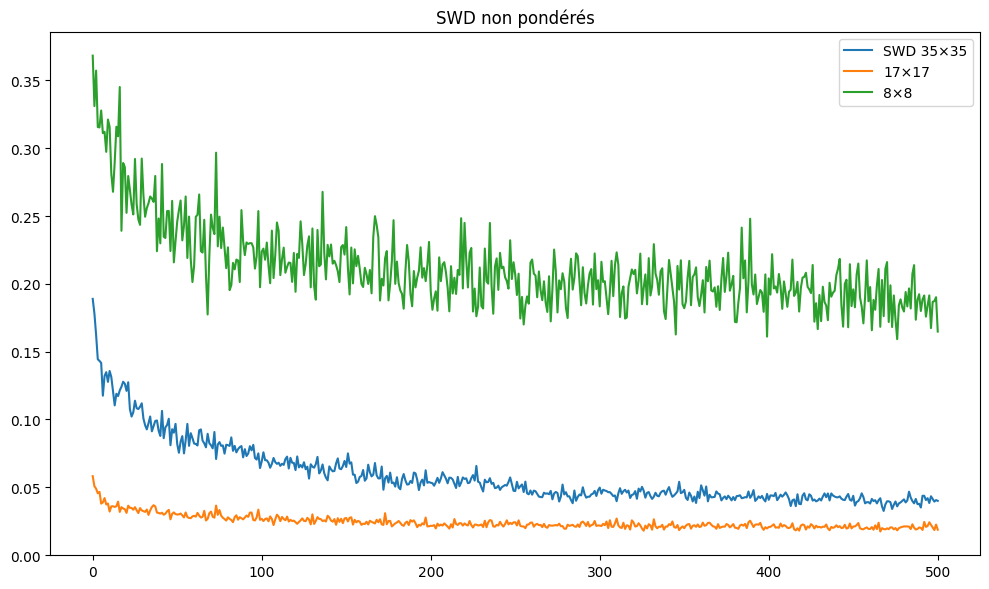

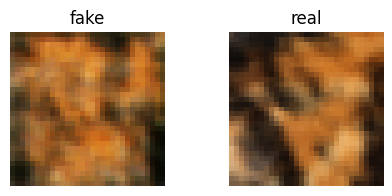

scale 3:  50%|█████     | 1000/2000 [01:03<01:06, 15.06it/s]

[it 1000] λ=[0.7002357244491577, 0.699999988079071, 0.6997643113136292]  swd=['0.024', '0.014', '0.121']  ratio=1.42  σ=1.03e+00  lr=1.0e-03


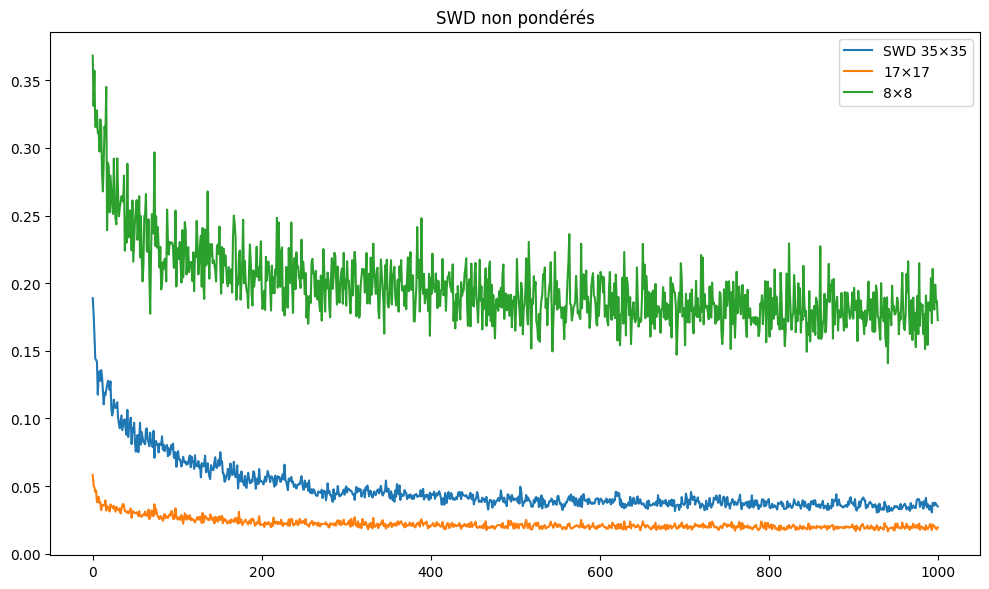

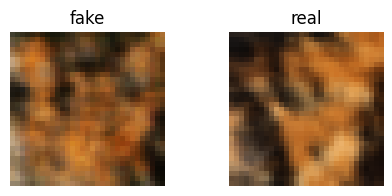

scale 3:  75%|███████▌  | 1500/2000 [01:36<00:31, 15.85it/s]

[it 1500] λ=[0.9123819470405579, 0.699999988079071, 0.4876180589199066]  swd=['0.026', '0.014', '0.086']  ratio=1.72  σ=1.04e+00  lr=1.0e-03


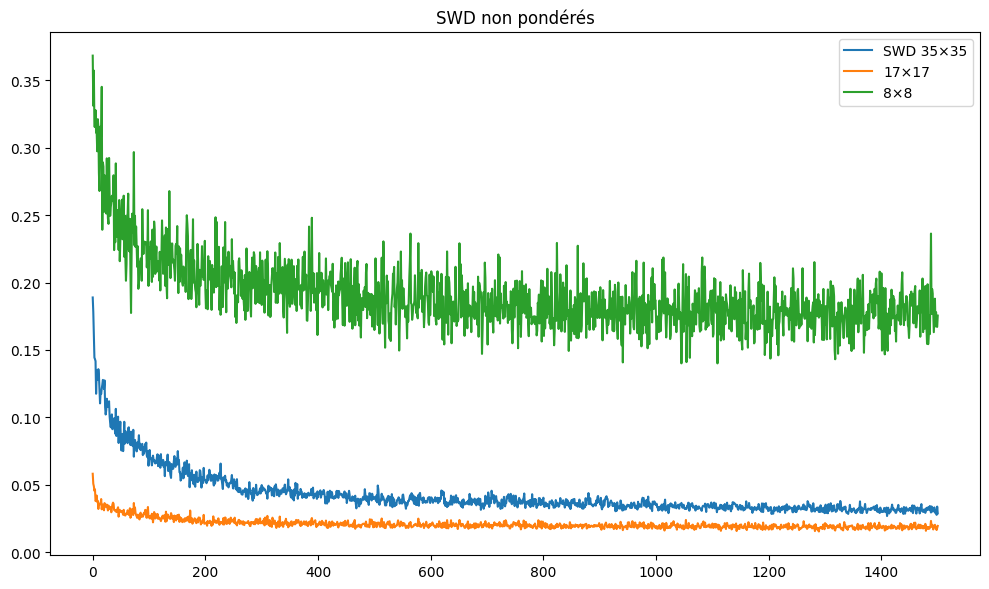

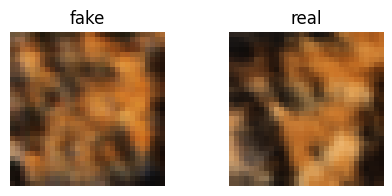

scale 3: 100%|█████████▉| 1999/2000 [02:06<00:00, 15.41it/s]

[it 1999] λ=[1.0, 0.699999988079071, 0.4000000059604645]  swd=['0.030', '0.015', '0.065']  ratio=1.96  σ=1.06e+00  lr=1.0e-03


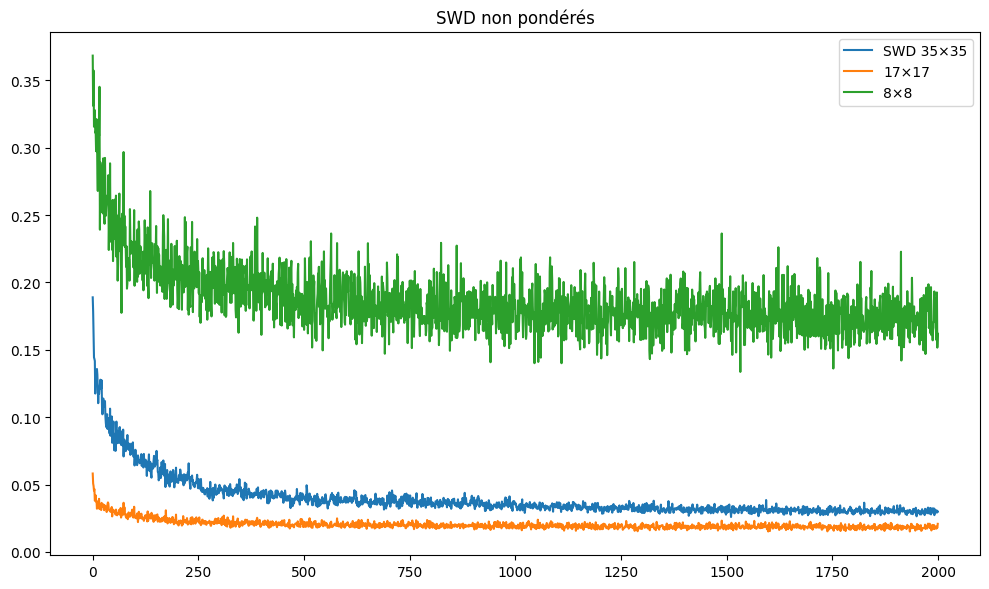

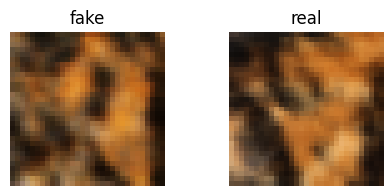

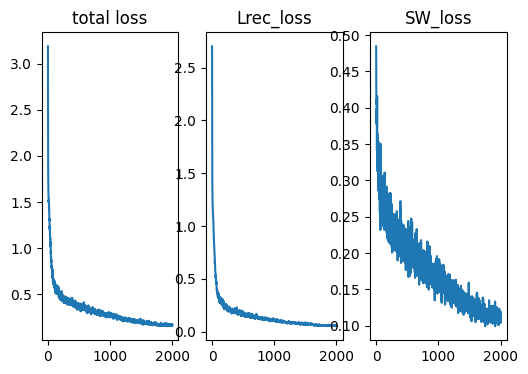

scale 2:  25%|██▌       | 500/2000 [00:36<01:39, 15.07it/s]

[it  500] λ=[0.4879513382911682, 0.6999999284744263, 0.9120486378669739]  swd=['0.021', '0.014', '0.134']  ratio=1.64  σ=2.22e-02  lr=1.0e-03


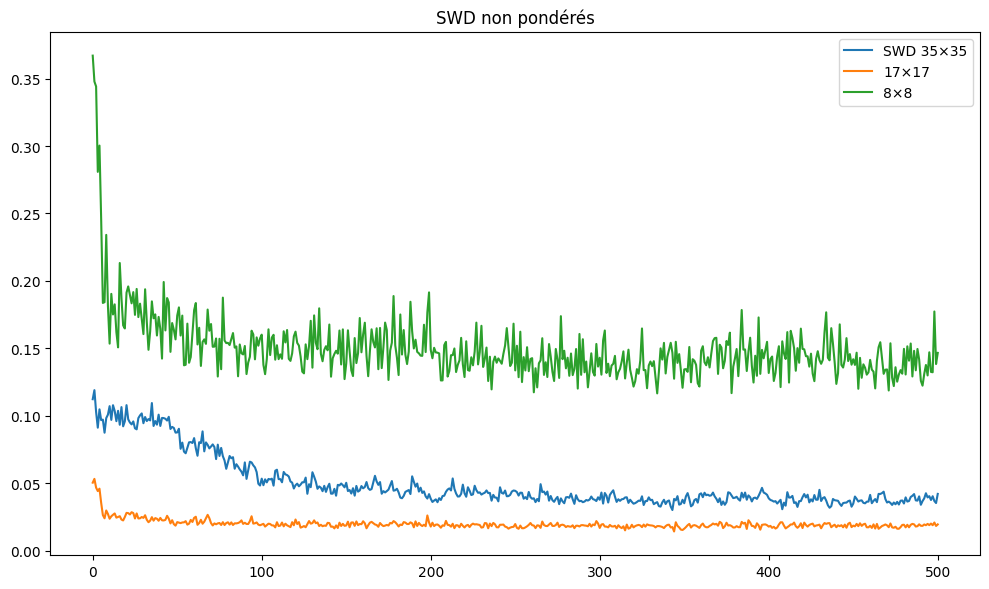

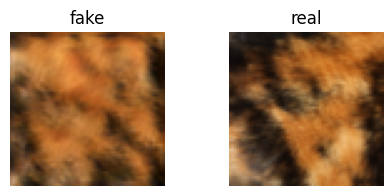

scale 2:  50%|█████     | 1000/2000 [01:09<01:14, 13.41it/s]

[it 1000] λ=[0.7002357244491577, 0.699999988079071, 0.6997643113136292]  swd=['0.023', '0.013', '0.091']  ratio=1.39  σ=2.46e-02  lr=1.0e-03


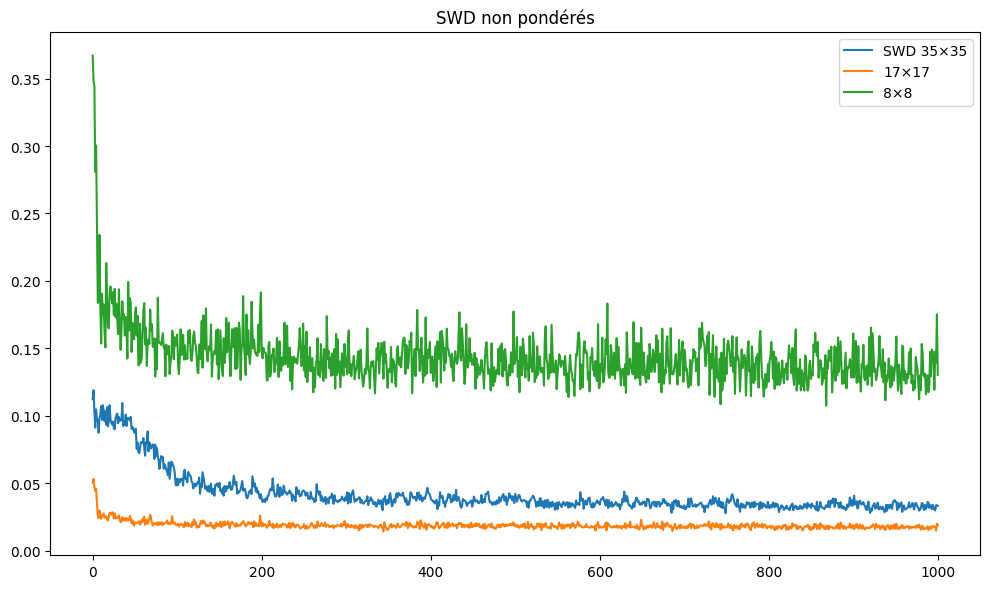

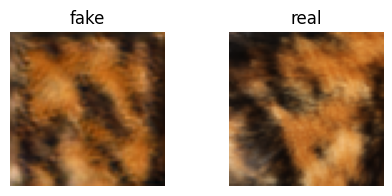

scale 2:  75%|███████▍  | 1499/2000 [01:46<00:33, 14.81it/s]

[it 1500] λ=[0.9123819470405579, 0.699999988079071, 0.4876180589199066]  swd=['0.026', '0.012', '0.071']  ratio=1.30  σ=2.61e-02  lr=1.0e-03


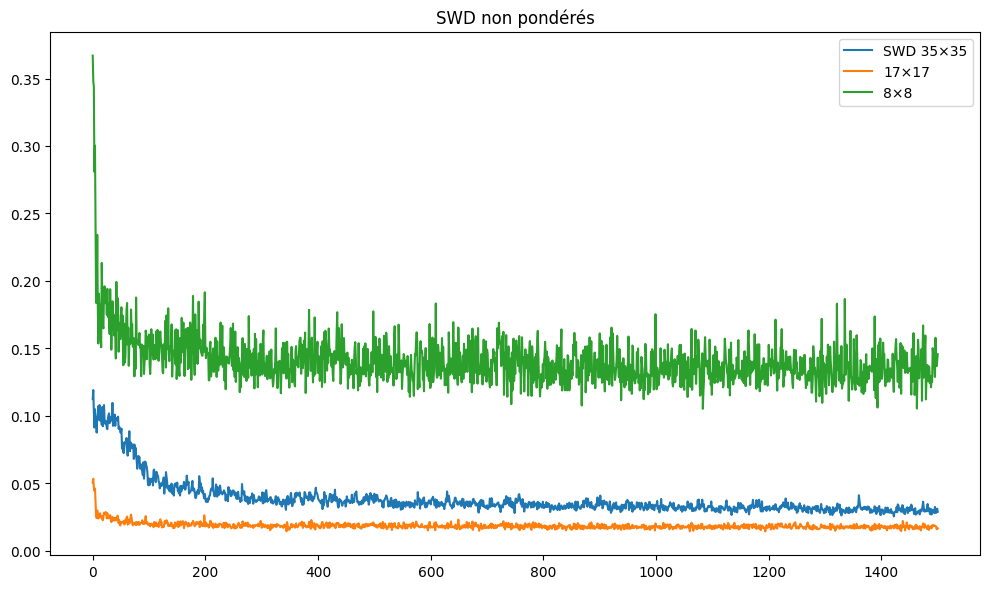

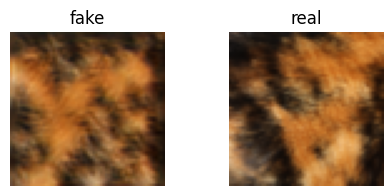

scale 2: 100%|█████████▉| 1999/2000 [02:20<00:00, 13.72it/s]

[it 1999] λ=[1.0, 0.699999988079071, 0.4000000059604645]  swd=['0.028', '0.011', '0.054']  ratio=1.22  σ=2.72e-02  lr=1.0e-03


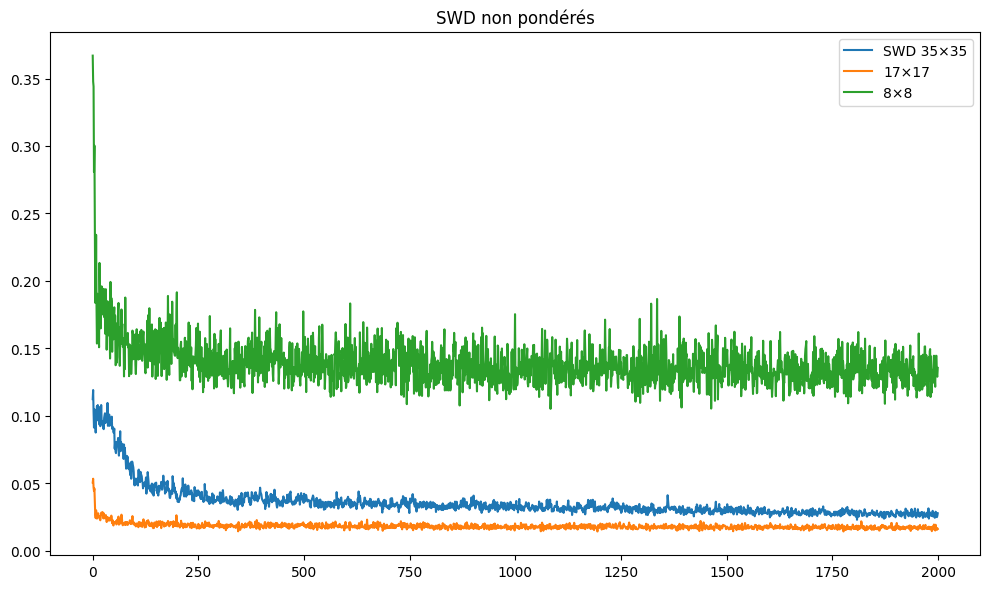

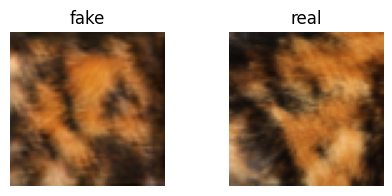

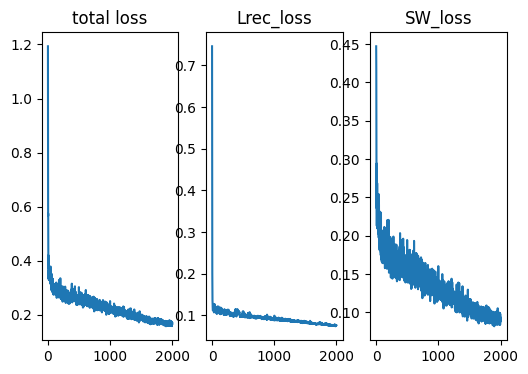

scale 1:  25%|██▍       | 499/2000 [00:50<01:17, 19.26it/s]

[it  500] λ=[0.4879513382911682, 0.6999999284744263, 0.9120486378669739]  swd=['0.020', '0.012', '0.116']  ratio=1.21  σ=2.24e-02  lr=1.0e-03


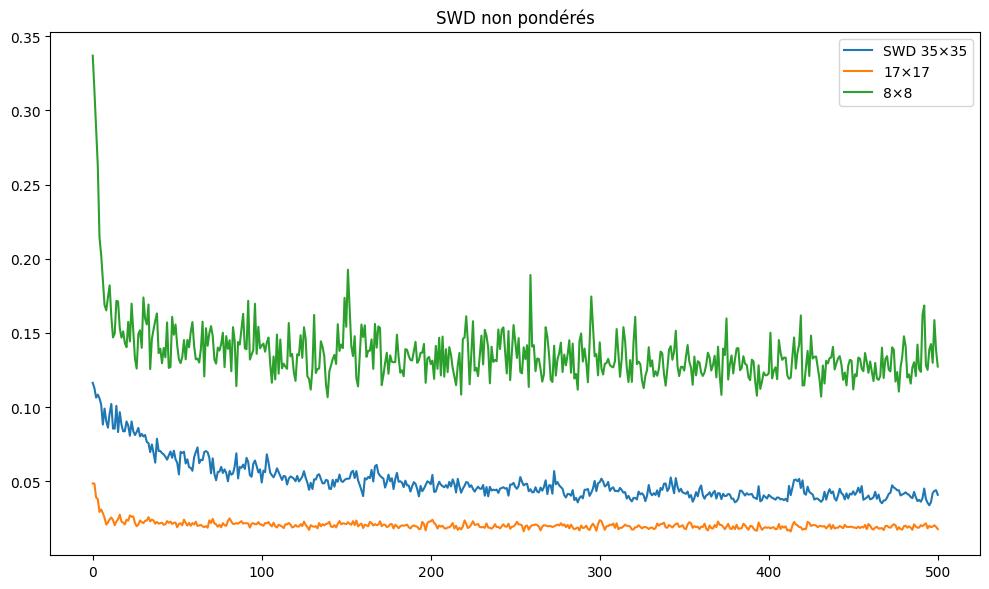

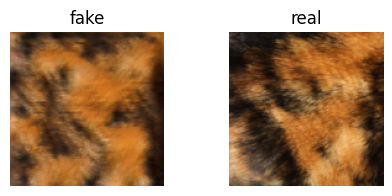

scale 1:  50%|█████     | 1000/2000 [01:42<01:51,  9.01it/s]

[it 1000] λ=[0.7002357244491577, 0.699999988079071, 0.6997643113136292]  swd=['0.023', '0.012', '0.077']  ratio=0.94  σ=2.45e-02  lr=1.0e-03


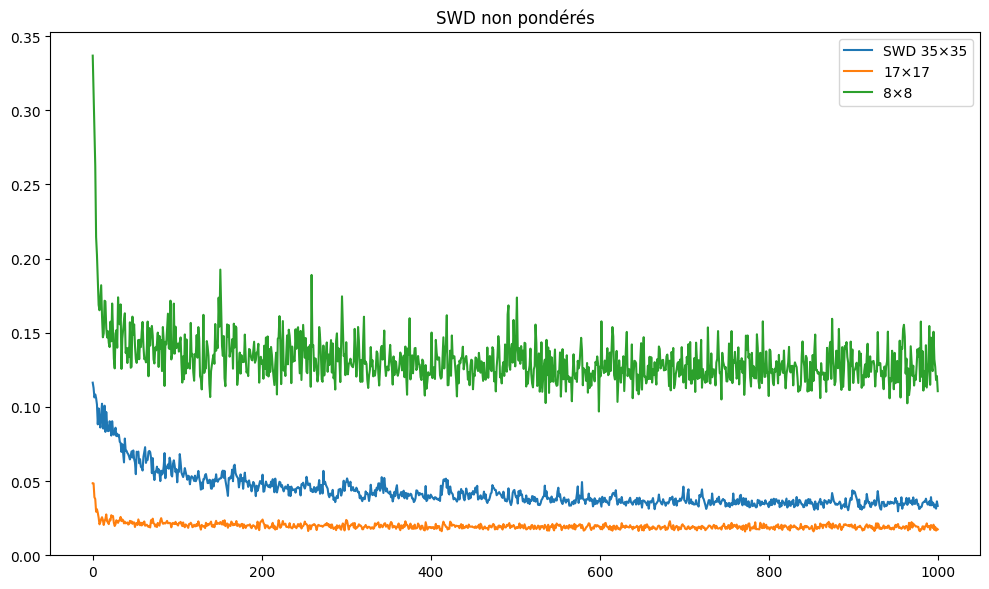

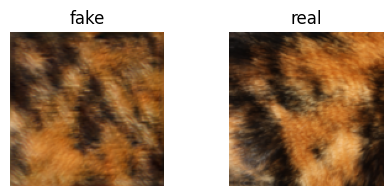

scale 1:  75%|███████▌  | 1500/2000 [02:33<00:54,  9.20it/s]

[it 1500] λ=[0.9123819470405579, 0.699999988079071, 0.4876180589199066]  swd=['0.029', '0.013', '0.062']  ratio=0.88  σ=2.57e-02  lr=1.0e-03


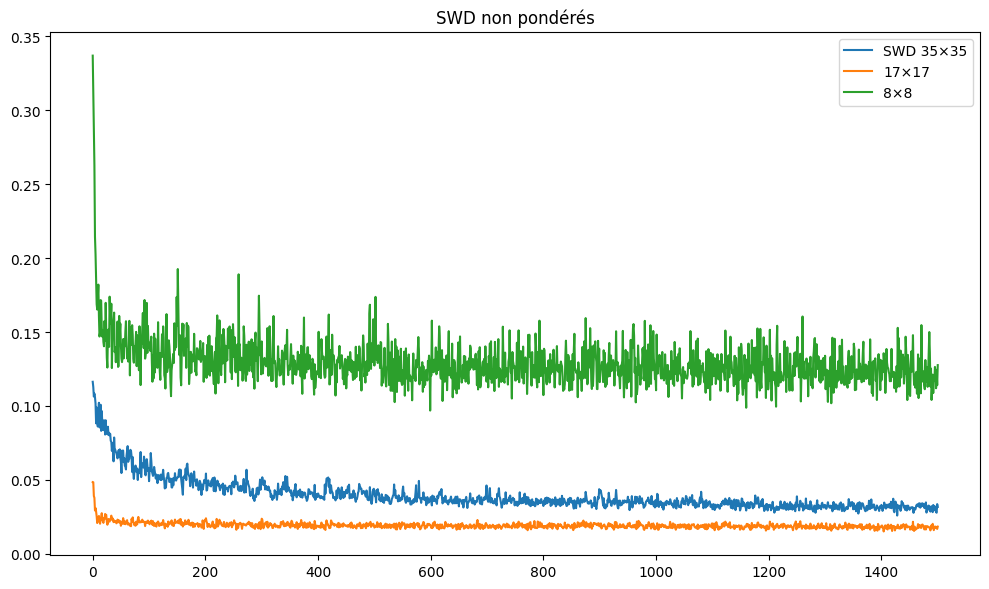

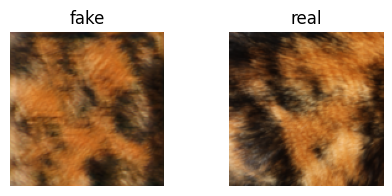

scale 1: 100%|█████████▉| 1999/2000 [03:22<00:00,  9.17it/s]

[it 1999] λ=[1.0, 0.699999988079071, 0.4000000059604645]  swd=['0.030', '0.012', '0.046']  ratio=0.75  σ=2.65e-02  lr=1.0e-03


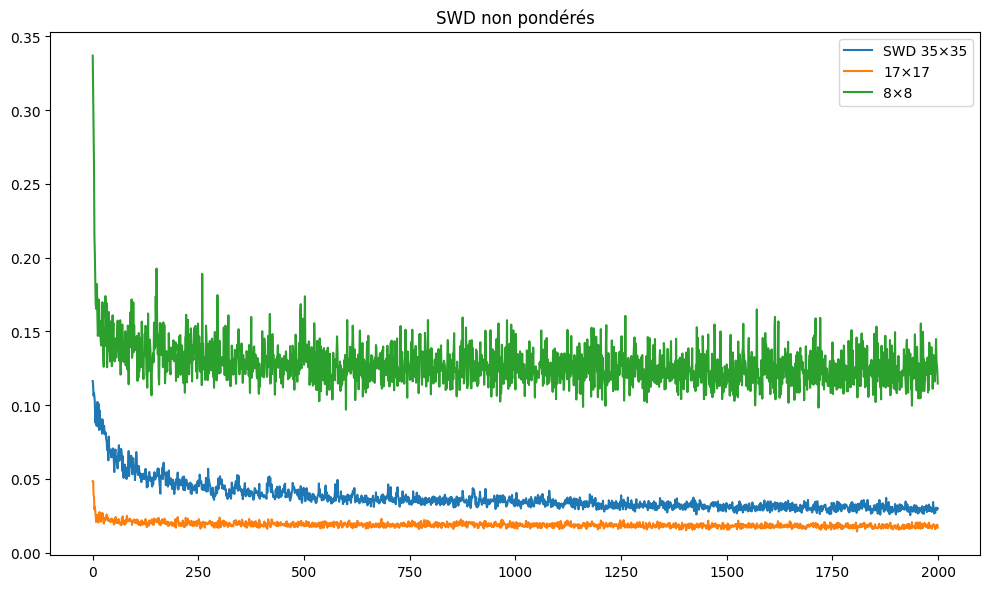

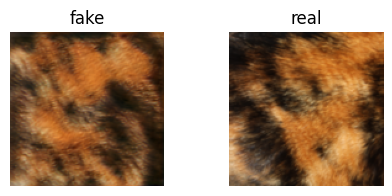

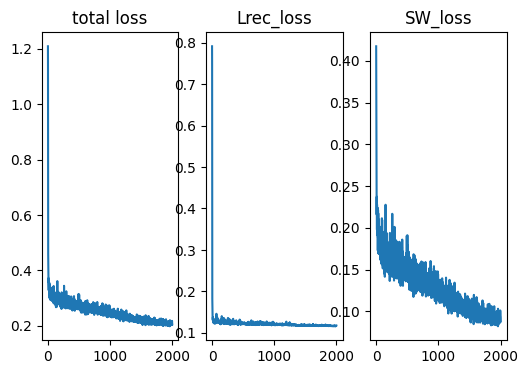

scale 0:  25%|██▌       | 500/2000 [03:15<09:44,  2.57it/s]

[it  500] λ=[0.4879513382911682, 0.6999999284744263, 0.9120486378669739]  swd=['0.020', '0.013', '0.127']  ratio=0.85  σ=2.48e-02  lr=1.0e-03


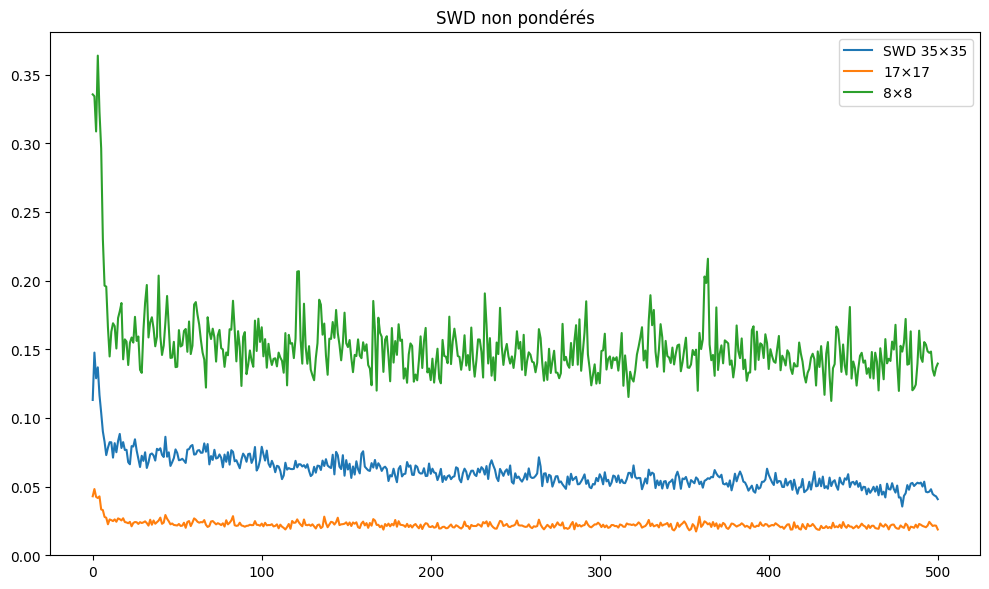

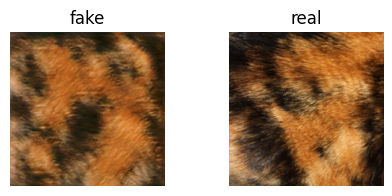

scale 0:  50%|█████     | 1000/2000 [06:28<06:36,  2.52it/s]

[it 1000] λ=[0.7002357244491577, 0.699999988079071, 0.6997643113136292]  swd=['0.026', '0.014', '0.101']  ratio=0.76  σ=2.83e-02  lr=1.0e-03


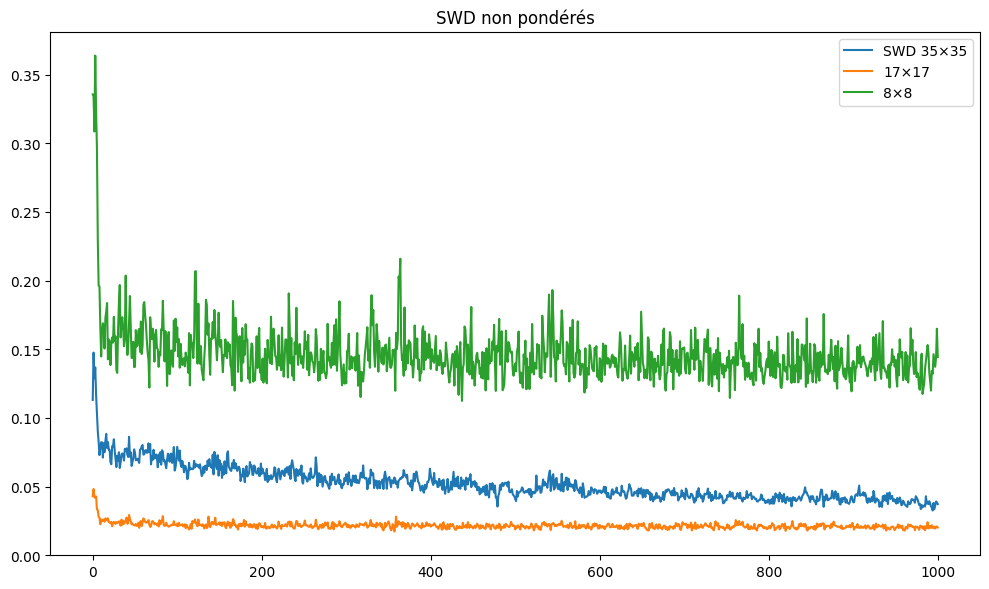

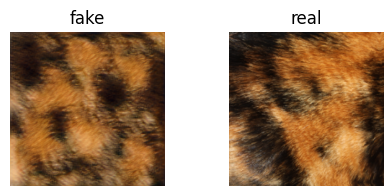

scale 0:  75%|███████▌  | 1500/2000 [09:45<02:11,  3.81it/s]

[it 1500] λ=[0.9123819470405579, 0.699999988079071, 0.4876180589199066]  swd=['0.031', '0.014', '0.070']  ratio=0.61  σ=3.03e-02  lr=1.0e-03


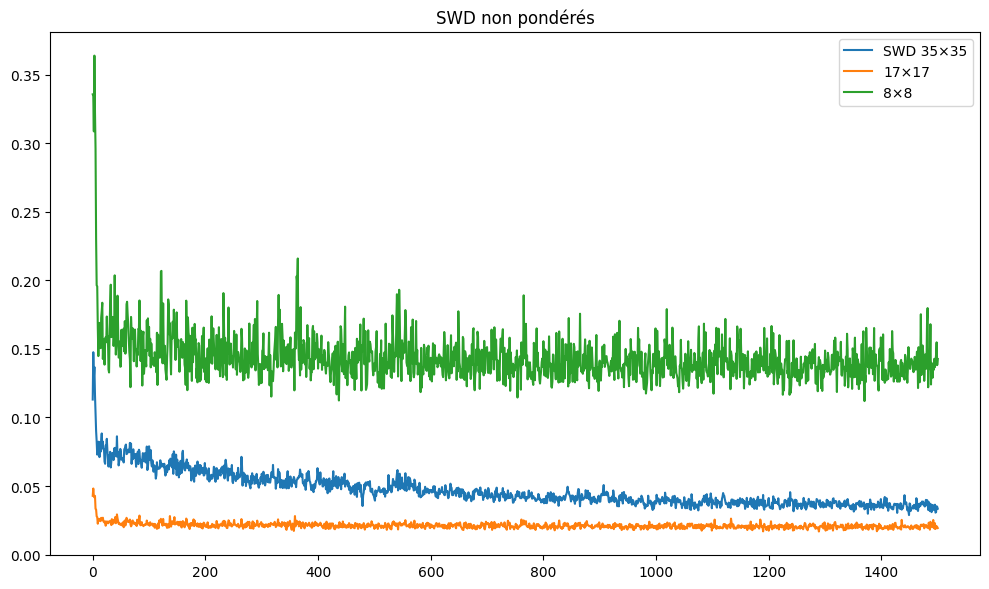

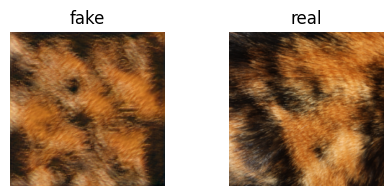

scale 0: 100%|█████████▉| 1999/2000 [13:01<00:00,  2.39it/s]

[it 1999] λ=[1.0, 0.699999988079071, 0.4000000059604645]  swd=['0.031', '0.015', '0.053']  ratio=0.54  σ=3.15e-02  lr=1.0e-03


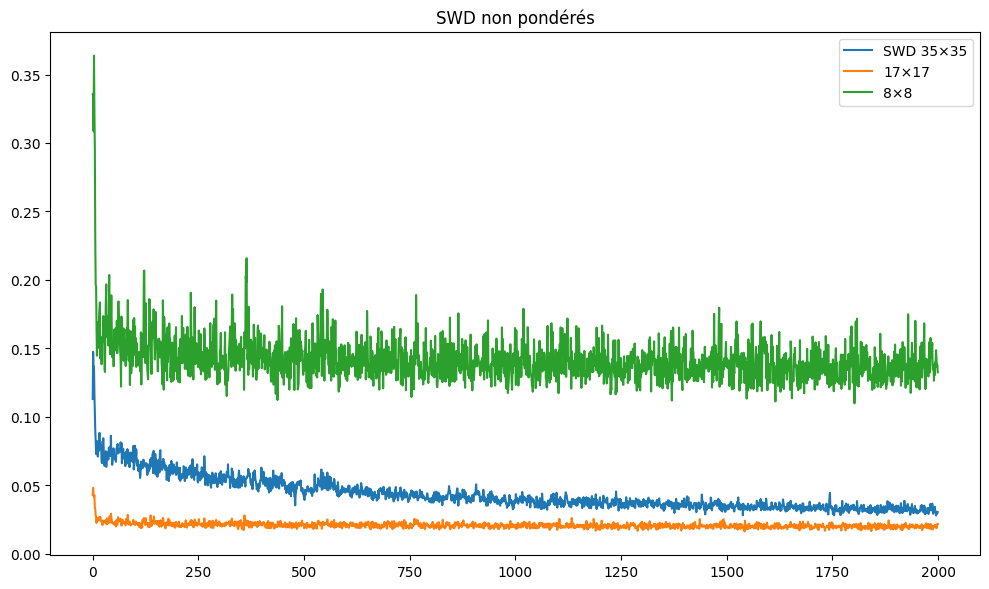

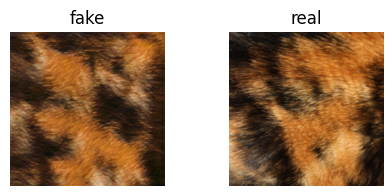

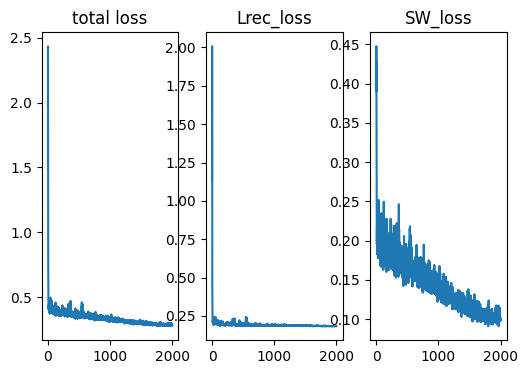

In [7]:
torch.random.manual_seed(1)

lr               = 1e-3
betas            = (0.9, 0.999)
base_iter        = 2000
alpha_rec        = 10.0
beta_sigma       = 0.1
b                = 4                     # batch‑size

# pondérations SWD : on les modifiera dynamiquement (GradNorm)
lambda_swd_init  = torch.tensor([0.4, 0.7, 1],device=device)   # (7c,6e,5d)
lambda_swd       = lambda_swd_init.clone()
lamda_swd_total  = 1.0

debug = True

for G in Genarators:
    G.apply(weights_init)


def sigma_pos(raw):                      # softplus → σ>0
    return F.softplus(raw)

sigma_raw = nn.ParameterList([           # un scalaire par scale
    nn.Parameter(torch.zeros((), device=device)) 
    for _ in range(N)
])


# reset des optim.
optimizer_G = []
for i in range(N):
    params = (list(Genarators[i].parameters()) + [sigma_raw[i]])          
    optimizer_G.append(optim.Adam(params, lr=lr, betas=betas))

scheduler_G = []

step_size   = 20000        # when to trigger the decay (20000 because we don't want decay ;))
gamma       = 0.1          # multiplicative factor

for opt_G in optimizer_G:
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )

z_star_shape = torch.stack([pyramids[i][-1].squeeze(0) for i in range(len(pyramids[:]))]).to(device)
z_star   = torch.randn_like(z_star_shape)               # bruit fixe
print(z_star.shape)
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(pyramids[0][-1]).to(device)]
       


@torch.no_grad()
def regenerate_prev_full(k: int, b: int):
    """
    Renvoie prev_img pour l'échelle k (shape = (b, C, Hk, Wk)) :
      • on part d'une image nulle au coarse (N-1) ;
      • on applique tous les G gelés (N-1 … k+1) avec bruit propre à CHAQUE
        élément du batch ;
      • on upsample à la résolution k.
    """
    # ----------- 0. raccourci coarse ---------------------------------------
    if k == N - 1:                       # échelle la plus grossière
        _, C, Hc, Wc = pyramids[0][k].shape   # scales[k] == (1,C,H,W)
        return torch.zeros(b, C, Hc, Wc, device=device)

    # ----------- 1. point de départ (N-1) ----------------------------------
    _, C, Hc, Wc = pyramids[0][-1].shape
    img = torch.zeros(b, C, Hc, Wc, device=device)        # (b,C,Hc,Wc)
    sigma_val = sigma_pos(sigma_raw[N-1]).item() 
    z  = torch.randn_like(img) * sigma_val
    img = Genarators[N - 1](z)                            # (b,C,Hc,Wc)

    # ----------- 2. remontée N-2 … k+1 -------------------------------------
    for s in range(N - 2, k, -1):
        _, _, Hs, Ws = pyramids[0][s].shape

        # upsample vers la taille courante s
        img_up = F.interpolate(img, size=(Hs, Ws),
                               mode='bilinear', align_corners=False)

        # bruit propre à chaque élément du batch
        sigma_val = sigma_pos(sigma_raw[s]).item()        
        z = torch.randn_like(img_up) * sigma_val

        # passage résiduel : G_s(z + img_up) + img_up
        img = Genarators[s](z + img_up) + img_up

    # ----------- 3. dernier upsample vers l'échelle k ----------------------
    _, _, Hk, Wk = pyramids[0][k].shape
    prev_img = F.interpolate(img, size=(Hk, Wk),
                             mode='bilinear', align_corners=False)
    return prev_img 


# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1
    Gk = Genarators[current_res].train()

    # --- real images à cette échelle 
    total_real = torch.stack([
        pyramids[i][current_res].squeeze(0) for i in range(len(pyramids))
    ]).to(device)

    # met en cache les features Inception de l'image real
    with torch.no_grad():
        rp   = preprocess_for_inception(total_real)
        rf32 = inception_model(rp)
        real_feats_all = [f.detach() for f in rf32]   
      
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    
    
    # Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1], size=total_real.shape[2:], mode='bilinear', align_corners=False)
        σ0 = beta_sigma * torch.sqrt(
                F.mse_loss(up_rec, total_real) /
                F.mse_loss(torch.zeros_like(total_real), total_real)
            )
    else:
        σ0 = torch.tensor(1., device=device)

    # convertit σ0 → raw tel que softplus(raw)=σ0
    sigma_raw[current_res].data.copy_(torch.log(torch.exp(σ0) - 1))
    total_loss_list = []
    Lrec_loss_list = []
    Sw_loss_list = []
    swd_raw_35, swd_raw_17, swd_raw_8 = [], [], []

    # itérations par scale
    iter_per_scale = base_iter 
    
    
    for it in tqdm(range(iter_per_scale), desc=f"scale {current_res}", leave=False):
        # -------- pondérations SWD : cos‑ramp ---------------------------
        t  = it / (iter_per_scale - 1)
        mix = 0.5 - 0.5 * torch.cos(torch.tensor(t * 3.1415926535))
        lambda_swd_tmp = (1.0 - mix) * lambda_swd_init + mix * torch.flip(lambda_swd_init, dims=[0])

        idx = torch.randint(0, total_real.size(0), (b,), device=device)
        xk_real  = total_real[idx]
        real_f = [f.index_select(0, idx) for f in real_feats_all]

        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res, b)
        
        sigma_cur = F.softplus(sigma_raw[current_res])
        z         = torch.randn_like(prev_img) * sigma_cur
        fake      = Gk(z + prev_img) + prev_img

        fake_pre  = preprocess_for_inception(fake)
        fake_f    = inception_model(fake_pre)          

        #  SWD loss
        Sw_loss      = []
        for i, (rf, ff, l) in enumerate(zip(real_f, fake_f, lambda_swd_tmp)):
            swd_i = sliced_wasserstein_distance(
                        preprocess_features(rf), preprocess_features(ff),
                        num_projections=128)
            if i == 2: swd_i_8  = swd_i   # Mixed_7c 8×8
            elif i == 1: swd_i_17 = swd_i # Mixed_6e
            else: swd_i_35 = swd_i        # Mixed_5d

            
            loss_i = l * swd_i
            Sw_loss.append(loss_i)

        swd_total = lamda_swd_total * torch.stack(Sw_loss).sum()

        #  reconstruction loss
        if current_res == N-1:
            rec_in  = z_star
            rec_out = Gk(rec_in)
        else:
            up_fixed = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            rec_in   = up_fixed
            rec_out  = Gk(rec_in) + up_fixed

        Lrec_loss = alpha_rec * F.mse_loss(rec_out, total_real)
        

        

        total_loss = Lrec_loss + swd_total 
     
        
        # -------- backward 
        optimizer_G[current_res].zero_grad()
        total_loss.backward()
        
        # clip 
        torch.nn.utils.clip_grad_norm_(Gk.parameters(), 1.0)
        optimizer_G[current_res].step()
        scheduler_G[current_res].step()

            
        total_loss_list.append(total_loss.item()) 
        Lrec_loss_list.append(Lrec_loss.item())
        Sw_loss_list.append(swd_total.item())
        
        # ----- SWD bruts non pondérés -----
        swd_raw_35.append(swd_i_35.item())   
        swd_raw_17.append(swd_i_17.item())
        swd_raw_8 .append(swd_i_8 .item())


        # logs
        if debug and ((it % 500 == 0  and it> 0 )or it==iter_per_scale-1):
            print(f"[it {it:4d}] "
                f"λ={lambda_swd_tmp.cpu().tolist()}  "
                f"swd={['%.3f'%l.item() for l in Sw_loss]}  "
                f"ratio={swd_total.item()/Lrec_loss.item():.2f}  "
                f"σ={sigma_cur.item():.2e}  "
                f"lr={opt_G.param_groups[0]['lr']:.1e}")

            plt.figure(figsize=(10,6))
            # plt.subplot(2,2,1); 
            plt.plot(swd_raw_35, label='SWD 35×35'); 
            plt.plot(swd_raw_17, label='17×17'); plt.plot(swd_raw_8, label='8×8')
            plt.legend(); plt.title('SWD non pondérés')


            plt.tight_layout(); plt.show()

            with torch.no_grad():
                plt.figure(figsize=(8,2))                        
                # --- fake ---
                plt.subplot(1,3,1)
                plt.imshow(pil_from_minus1to1(fake[0].cpu()))
                plt.axis('off'); plt.title('fake')

                # --- real ---
                plt.subplot(1,3,2)
                plt.imshow(pil_from_minus1to1(xk_real[0].cpu()))
                plt.axis('off'); plt.title('real')
                
                plt.show()
    
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake[0].detach())
        sigma_final = F.softplus(sigma_raw[current_res]).item()  # valeur apprise
        sigma_n[current_res] = sigma_final 
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                            
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)
    plt.figure(figsize=(6,4))
        
    plt.subplot(1,3,1)
    plt.plot(total_loss_list)
    plt.title("total loss")
    plt.subplot(1,3,2)
    plt.plot(Lrec_loss_list)
    plt.title("Lrec_loss")
    plt.subplot(1,3,3)
    plt.plot(Sw_loss_list)
    plt.title("SW_loss")

    plt.show()

+ Sauvegarde poids générateurs
+ Sauvegarde niveau de bruit utilisé
+ Sauvegarde z_star

In [8]:

image_name = "non_gaussian"                # dossier racine
model_name = "SWD"                          # sous-dossier
out_dir    = Path("models") / image_name / model_name
out_dir.mkdir(parents=True, exist_ok=True)

weights_fp = out_dir / "generators.pt"
descr_fp   = out_dir / "Description.txt"
sigma_fp   = out_dir / "sigma_n.json"
zstar_fp   = out_dir / "z_star.pt"

# Sauvegarde poids générateurs
torch.save([G.state_dict() for G in Genarators], weights_fp)
print(f"✓ générateurs sauvegardés  → {weights_fp}")


description = {
    "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
    "N_scales"       : N,
    "base_iter"      : base_iter,
    "lr"             : lr,
    "betas"          : betas,
    "alpha_rec"      : alpha_rec,
    "beta_sigma"     : beta_sigma,
    "lambda_swd_init": lambda_swd_init.tolist(),
    "lamda_swd_total": lamda_swd_total,
    "r" : RATIO,
    "comment"        : "Entraînement rapide SWD multi-échelle + MSE, sans discriminateur."
}
with open(descr_fp, "w", encoding="utf-8") as f:
    for k, v in description.items():
        f.write(f"{k}: {v}\n")
print(f"✓ description écrite       → {descr_fp}")

# Sauvegarde des variances du bruit à chaque échelle
sigma_list = [float(s.item() if torch.is_tensor(s) else s) for s in sigma_n]
with open(sigma_fp, "w", encoding="utf-8") as f:
    json.dump(sigma_list, f, indent=2)
print(f"✓ sigma_n sauvegardé       → {sigma_fp}")

# Sauvegarde du bruit fize z_star
torch.save(z_star[0], zstar_fp)
print(f"✓ z_star sauvegardé        : {zstar_fp}")


✓ générateurs sauvegardés  → models/non_gaussian/SWD/generators.pt
✓ description écrite       → models/non_gaussian/SWD/Description.txt
✓ sigma_n sauvegardé       → models/non_gaussian/SWD/sigma_n.json
✓ z_star sauvegardé        : models/non_gaussian/SWD/z_star.pt
